In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import cv2
from keras import regularizers
import os
import pandas as pd
import glob
import numpy as np
import time
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Operation system

In [2]:
import warnings

warnings.filterwarnings('ignore')
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
!python3 --version
print(device_lib.list_local_devices()[1])
print('tensorflow version: ',tf.__version__)
print('keras version: ',keras.__version__)

Python 3.6.6
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12197958320915651047
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0e:00.0, compute capability: 6.1"

tensorflow version:  1.10.0
keras version:  2.2.2


# Information of class

In [3]:
from sklearn.utils import shuffle

file_name = 'train_labels.csv'
whereami_img = pd.read_csv(file_name)
seed = int(time.time())
whereami_img = shuffle(whereami_img, random_state=seed)
print(whereami_img.head())
print(whereami_img.tail())
#print(whereami_img.id.value_counts())
classlst = os.listdir('train/')

batch_size = 16

       id  appliance
137  1137          5
749  1749          8
926  1926          7
741  1741          3
591  1591          1
       id  appliance
639  1639          1
857  1857          6
161  1161          1
131  1131          2
876  1876         10


In [4]:
listx= pd.DataFrame(whereami_img['id'])
listy= pd.DataFrame(whereami_img['appliance'])
print(listx.head())
print(listy.head())
#x_train1, y_train1, x_valid1 , y_valid1 = train_test_split(listx, listy,test_size=0.2,random_state=5)
# print(x_train1.head())
# print(x_valid1.head())

       id
137  1137
749  1749
926  1926
741  1741
591  1591
     appliance
137          5
749          8
926          7
741          3
591          1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(988, 11)


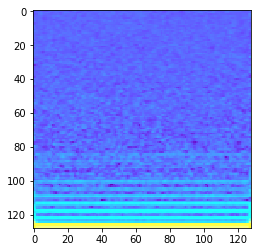

In [7]:
#from librosa.decompose import decompose
n_size= img_size = 128
re_size=(img_size,img_size)
x_train = []
y_train1 = []
x_valid = []
y_valid = []
for f in listx['id']:
    filename = './/train//'+str(f)+'_v.png'
    #print(f)
    if os.path.isfile(filename):
        img = cv2.imread(filename)
        #img = io.imread(filename, as_gray=True)
        #librosa.core.db_to_power
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img - np.array([123.68, 116.779, 103.939])
        #img2 = img[:,:,::-1]  # RGB to BGR
        img = (img - np.min(img)) / np.max(img)
        #img2 = (img2 - np.min(img2)) / np.max(img2)
        #img=(img+img2)/2
        x_train.append(np.asarray(img))
        #print(type(x_train))
    else:
        print ("The file " + filename + " does not exist.")

num_classes=11
        
for f in listy['appliance']:
    y_train1.append(f)
    #print(y_train)
y_train=keras.utils.to_categorical(y_train1, num_classes)
print(y_train.shape)
plt.imshow(x_train[0])

In [8]:
print(type(x_train))
x_train = np.array(x_train, dtype=np.float32)
print(type(x_train))

<class 'list'>
<class 'numpy.ndarray'>


In [9]:
print(y_train.shape)


(988, 11)


In [10]:
print(len(y_train))
print(len(x_train))
x_train1, x_valid1, y_train1 , y_valid1 = train_test_split(x_train, y_train,test_size=0.1,random_state=2)


988
988


## define image generator

In [12]:
def keras_train_normolize(x_input,x_test_input):
    x_input = x_input.astype('float32')
    x_test_input = x_test_input.astype('float32')
    #x_input /= 255.
    x_test_input /= 255.
    return x_input, x_test_input


In [13]:
from tqdm import tqdm_notebook #用來顯示進度條的套件
from sklearn.metrics import accuracy_score



#update_per_epoch = 100 #一個epoch要跑幾個batch
'''因為我們現在是用generator產生新的batch，所以我們要自行給定一個epoch要跑幾個batch,
當然也可以另外修改程式讓generator回傳適合的batch數(total number of data/batch size)'''


x_train, y_train = keras_train_normolize(x_train1, y_train1)
x_valid, y_valid = keras_train_normolize(x_valid1, y_valid1)
#x_train = x_train[train_index].reshape(-1,790)
print(x_train.shape)
print(y_train.shape)

(889, 128, 128, 3)
(889, 11)


## inception_resnet

In [14]:
# #InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras import regularizers
#from keras.layers.noise import AlphaDropout

def ResNetV2_model():
    base_model = InceptionResNetV2(weights=None, include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(1024, activation='relu')(x)

    predictions = Dense(11, activation='softmax')(x)

# this is the model we will train
    return Model(inputs=base_model.input, outputs=predictions)

#base_model = InceptionResNetV2(weights='imagenet', include_top=True)
#print(base_model.summary())
model= ResNetV2_model()
#print(ResNetV2.summary())

In [17]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
# datagen = ImageDataGenerator(
#     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True)  # randomly flip images

datagen = ImageDataGenerator(
#     featurewise_center=True,
#     samplewise_center=True,
#     featurewise_std_normalization=True,
#     samplewise_std_normalization=True,
    #fill_mode='constant',
    rotation_range=0.01,
    width_shift_range=0.01,
    height_shift_range=0.01,
#    horizontal_flip=True,
#     vertical_flip=False,
#    rescale= 1./255
    #zca_whtening = True
    )


datagen.fit(x_train)

# datagen.fit(x_train1)
# datagen.fit(x_train2)


Using real-time data augmentation.


In [18]:
# Use ModelCheckpoint to save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_whereami_trained_model_v.h5'


if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

#checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
model_train = 0


In [19]:
# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
#earlystop = EarlyStopping(monitor='val_acc', patience=15, verbose=1)

model_train = model#Xception_transfer#ResNetV2#NASNetL#ResNetV2#inceptv4#DenseNet_201 #model_inv3 #model_inv3

epochs=100

def train_model(Model_train, X_train, Y_train, X_test, Y_test, Checkpoint,Earlystop):
    #with tf.device('/device:GPU:1'):
    model_history = Model_train.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    #steps_per_epoch=20,
                    #class_weight = 'auto',
                    shuffle=True,                          
                    validation_data=(X_test, Y_test),
                    workers=4,
                    callbacks=[Checkpoint, Earlystop])
                    #callbacks=[Earlystop])
    
    return model_history, Model_train  


if(os.path.isfile(model_path1)):
    model_train.load_weights('./saved_models/keras_whereami_trained_model1.h5')
    print ("Load weight of keras_whereami_trained_model1.h5 ok")
    

#lr = 0.01*(batch_size/256) #0.000125
#lr = 0.0001
lr = 0.01
#opt = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=0.1,decay=0.001)
opt = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=0.1,decay=0.00001)

model_train.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


tStart = time.time()#計時開始

model_history, model_train_final=train_model(model_train, x_train,y_train,x_valid,y_valid,checkpoint,earlystop)

tEnd = time.time()#計時結束  

print ("The final step cost %f sec" % (tEnd - tStart))

Load weight of keras_whereami_trained_model1.h5 ok
Epoch 1/100
56/56 [==============================] - 46s 823ms/step - loss: 5.3853e-04 - acc: 0.9665 - val_loss: 3.0659e-04 - val_acc: 0.9899

Epoch 00001: val_loss improved from inf to 0.00031, saving model to /home/jovyan/edx/saved_models/keras_whereami_trained_model.h5
Epoch 2/100
56/56 [==============================] - 14s 247ms/step - loss: 5.4621e-04 - acc: 0.9676 - val_loss: 2.9658e-04 - val_acc: 0.9899

Epoch 00002: val_loss improved from 0.00031 to 0.00030, saving model to /home/jovyan/edx/saved_models/keras_whereami_trained_model.h5
Epoch 3/100
56/56 [==============================] - 14s 252ms/step - loss: 5.5967e-04 - acc: 0.9542 - val_loss: 2.9147e-04 - val_acc: 0.9899

Epoch 00003: val_loss improved from 0.00030 to 0.00029, saving model to /home/jovyan/edx/saved_models/keras_whereami_trained_model.h5
Epoch 4/100
56/56 [==============================] - 14s 243ms/step - loss: 5.0399e-04 - acc: 0.9659 - val_loss: 2.9109e-0

## Load model to eva

In [21]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate(x_valid, y_valid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
99/99 [==============================] - 6s 57ms/step
Test loss: 0.00025187757207525215
Test accuracy: 0.98989898989899


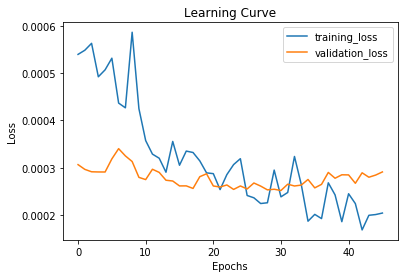

In [22]:
if(model_train!=0):
    training_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.plot(training_loss, label="training_loss")
    plt.plot(val_loss, label="validation_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend(loc='best')
    plt.show()

## Start to get result from testset

In [24]:
import ntpath


def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

test_path = os.path.join(os.getcwd(), 'test')
# test_list = glob.glob(os.path.join(test_path, '*_c.png'))
# test_id = [path_leaf(s).strip('_c.png') for s in test_list]
# print(len(test_id))
test_list1 = glob.glob(os.path.join(test_path, '*_v.png'))
test_id1 = [path_leaf(s).strip('_v.png') for s in test_list1]
print(len(test_id1))

659


In [25]:
test_data_list =[]
#re_size =(n_size,n_size)

for i in range(len(test_list1)):
#     img = cv2.imread(test_list[i])
#     img = cv2.resize(img,re_size)
#     img = img.astype(np.float32)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img - np.array([123.68, 116.779, 103.939])
    img = cv2.imread(test_list1[i])
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img - np.array([123.68, 116.779, 103.939])
    #img = img[:,:,::-1]  # RGB to BGR
    img = (img - np.min(img)) / np.max(img)
   
    test_data_list.append(img)
    
test_data = np.array(test_data_list)    
#test_data = test_data.astype('float32')
#test_data /= 255
print(test_data.shape)

(659, 128, 128, 3)


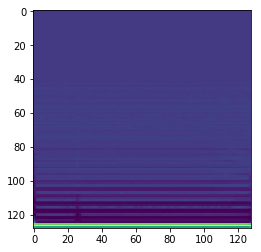

In [26]:
plt.imshow(test_data[0][:,:,0])
plt.show()   

In [27]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([ 2,  1,  2,  5,  1,  5,  8,  8,  3,  6,  1,  5,  0,  8,  2,  2,  1,
        9,  5,  5,  2,  5,  0,  3,  9,  1,  5,  1,  7,  3,  2,  0,  8,  8,
        2,  2,  9,  0,  2,  0,  8,  3,  3,  5,  5,  7,  5,  0,  3,  3,  8,
        8,  7,  7,  3,  1,  8,  8,  3,  1,  4, 10,  3, 10,  2,  5,  2,  2,
        5,  1,  3,  3,  2,  5,  5,  1,  3,  5,  0,  8,  8,  8,  2,  5,  8,
        0,  7,  5,  2,  6,  2,  8,  2,  8,  0,  5,  8,  0,  1,  0,  3,  5,
        0,  2,  5,  4,  2,  5,  0,  3,  1,  1,  2,  0,  6,  1,  0,  5,  1,
        1,  5,  1,  3,  3,  3,  2,  3,  3, 10,  1,  1,  1,  7,  2,  8,  8,
        0,  8,  5,  7,  6,  9,  5,  8,  4,  0,  0,  0,  8,  8,  6,  1,  0,
        1,  2,  0,  1,  1,  1,  8,  2,  5,  5,  0,  8,  1,  2,  3,  8,  3,
        8,  1,  7,  2,  9,  8,  2,  9,  8,  0,  0,  0,  6,  5,  2,  8,  2,
        2,  2,  8,  5,  0,  1,  3,  5, 10,  3,  6,  2, 10,  0,  7,  6,  9,
        5,  8,  4,  0,  0,  6,  8, 10,  8,  1,  1,  9,  2,  1,  3,  3,  7,
        2, 10,  4,  6,  8

In [28]:
print(len(y_pred))

659


In [31]:
df = pd.DataFrame( {"id": test_id1, "appliance": pd.Series(y_pred)} )
df = df[['id', 'appliance']]
df=df.sort_values (["id"])
#df=df.sort_values (["id"],ascending=True)
df.to_csv('submission_data_v.csv', index = False)

In [32]:
df.head(20)

,id,appliance
168,1988,8
367,1989,3
570,1990,2
143,1991,8
187,1992,2
315,1993,7
6,1994,8
123,1995,3
64,1996,2
382,1997,8
